# Supervised Fine-Tuning (SFT) on a Tiny Language Model

## Introduction 

Modern language models are powerful because they learn general language patterns from large corpora. But if we want them to follow instructions reliably, we need to adapt them further with Supervised Fine-Tuning (SFT).

SFT is a simple idea: take a pre-trained model, and train it on curated prompt–response pairs so that it learns the exact behavior we want.


In this blog, we’ll explore SFT step by step with:

- a tiny instruction dataset

- a small causal GPT-style model

- clear explanations of each concept

- runnable code + outputs

To understand the core ideas without getting lost in complexity, we’ll use a minimal setup. This will help us grasp the fundamentals of SFT before scaling up to larger models and datasets.

## Setup
 
Install the required libraries:

```bash
pip install transformers datasets accelerate
```

In [15]:
import numpy as np
from pprint import pprint

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
import torch.nn.functional as F
from datasets import load_dataset

In [54]:
# for plotting anf logging 
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd
import matplotlib.pyplot as plt

## Choose a Pre-trained Model

We're using `distilgpt2`, distilled, smaller version of GPT-2. It’s lightweight and fast, but still can be used to demonstrate SFT concepts. We'll load the model and its tokenizer using the `transformers` library.

In [ ]:
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)


In [7]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 81912576
Trainable parameters: 81912576


## Choose the Dataset.

We'll use publicly avaialable `alpaca` dataset from `datasets` library. The `alpaca` dataset contains instruction-response pairs that is predominantly used for fine-tuning language models to follow instructions.

In [9]:
dataset = load_dataset("tatsu-lab/alpaca")
print(dataset)

Generating train split: 100%|██████████| 52002/52002 [00:00<00:00, 839755.43 examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'text'],
        num_rows: 52002
    })
})


In [14]:
number_of_examples = len(dataset["train"])
print(f'Number of training examples: {number_of_examples}')

Number of training examples: 52002


In [17]:
# print sample data
random_index = np.random.randint(0, number_of_examples)
pprint(dataset['train'][random_index])

{'input': 'The effects of colonialism on the culture and economy of Native '
          'American tribes',
 'instruction': 'Identify a suitable primary source for the following research '
                'topic.',
 'output': 'Original documents from the Bureau of Indian Affairs or oral '
           'histories from tribal members.',
 'text': 'Below is an instruction that describes a task, paired with an input '
         'that provides further context. Write a response that appropriately '
         'completes the request.\n'
         '\n'
         '### Instruction:\n'
         'Identify a suitable primary source for the following research '
         'topic.\n'
         '\n'
         '### Input:\n'
         'The effects of colonialism on the culture and economy of Native '
         'American tribes\n'
         '\n'
         '### Response:\n'
         'Original documents from the Bureau of Indian Affairs or oral '
         'histories from tribal members.'}


This dataset has examples with the following template:

- `instruction`: The task or question to be answered.
- `input`: Additional context or information (can be empty).
- `output`: The desired response from the model.
- `text`: A combined string of instruction, input, and output.

For our purposes, we will combine the `instruction` and `input` into a prompt and use `output` as the target.

## Loss Masking Strategy

When we fine-tune a causal LM, we provide a prompt and teacher response together as tokens, but we want the model to learn only on the response part.

That means:

- Tokens for the prompt should not contribute to training loss
- Only the assistant response tokens should be learned

We do this with a label mask (set to -100 for prompt tokens), so the model focuses training on the response only.


## Build a Custom Dataset Class

In [18]:
IGNORE_INDEX = -100

class AlpacaSFTDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=256):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        ex = self.dataset[idx]
        instr = ex["instruction"]
        inp = ex["input"]
        out = ex["output"]

        # Build prompt
        prompt = instr + (": " + inp if inp else "")
        prompt_ids = self.tokenizer.encode(prompt, add_special_tokens=False)
        response_ids = self.tokenizer.encode(out, add_special_tokens=False)

        input_ids = prompt_ids + response_ids
        input_ids = input_ids[: self.max_length]
        
        # Mask prompt tokens
        labels = [IGNORE_INDEX] * len(prompt_ids) + response_ids
        labels = labels[: self.max_length]

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "labels": torch.tensor(labels, dtype=torch.long),
        }

In [31]:
ds = AlpacaSFTDataset(
    dataset=dataset["train"],
    tokenizer=tokenizer
)
sample = ds[0]
pprint(sample)

{'input_ids': tensor([23318,  1115,  9040,   329, 10589,  5448,    13,    16,    13, 47659,
          257, 12974,  5496,   290,   787,  1654,   284,  2291,  6088,   286,
        15921,   290, 13701,    13,   220,   198,    17,    13, 32900,  7987,
          284,  1394,   534,  1767,  4075,   290,  1913,    13,   220,   198,
           18,    13,  3497,  1576,  3993,   290,  5529,   257,  6414,  3993,
         7269,    13]),
 'labels': tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,    16,    13, 47659,
          257, 12974,  5496,   290,   787,  1654,   284,  2291,  6088,   286,
        15921,   290, 13701,    13,   220,   198,    17,    13, 32900,  7987,
          284,  1394,   534,  1767,  4075,   290,  1913,    13,   220,   198,
           18,    13,  3497,  1576,  3993,   290,  5529,   257,  6414,  3993,
         7269,    13])}


We can see that the sample `input_ids` contains both the prompt and the response tokens. To ensure that the model only learns from the response, we need to create a label mask.

Inspecting the `sample`, we can identify the index where the response starts. We will set all tokens before this index to -100 in the `labels` tensor.

In [30]:
print(tokenizer.decode(sample["input_ids"]))

labels = sample["labels"].tolist()
decoded_output = tokenizer.decode([id for id in labels if id != IGNORE_INDEX])
for i in range(len(labels)):
    if labels[i] == IGNORE_INDEX:
        print(f"{tokenizer.pad_token} ", end="")
    else:
        print(f"{tokenizer.decode(labels[i])}", end="")
    


Give three tips for staying healthy.1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. 
2. Exercise regularly to keep your body active and strong. 
3. Get enough sleep and maintain a consistent sleep schedule.
None None None None None None None 1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. 
2. Exercise regularly to keep your body active and strong. 
3. Get enough sleep and maintain a consistent sleep schedule.

## Training Setup

In [ ]:
train_ds = AlpacaSFTDataset(dataset["train"], tokenizer)

training_args = TrainingArguments(
    output_dir="../../workspace/alpaca-sft", # change to your desired output directory
    per_device_train_batch_size=1,
    gradient_accumulation_steps=100,
    num_train_epochs=1,
    logging_steps=100,
    save_strategy="no"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds
)

### Train the model

In [43]:
trainer.train()

Step,Training Loss


RuntimeError: MPS backend out of memory (MPS allocated: 2.12 GiB, other allocations: 15.90 GiB, max allowed: 18.13 GiB). Tried to allocate 147.24 MiB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

### Plot the training loss

("Available tags: ['train/loss', 'train/grad_norm', 'train/learning_rate', "
 "'train/epoch', 'train/train_runtime', 'train/train_samples_per_second', "
 "'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']")
           time  step   value
0  1.769937e+09   100  2.8134
1  1.769937e+09   200  2.7355
2  1.769937e+09   300  2.6881
3  1.769937e+09   400  2.7005
4  1.769937e+09   500  2.6361


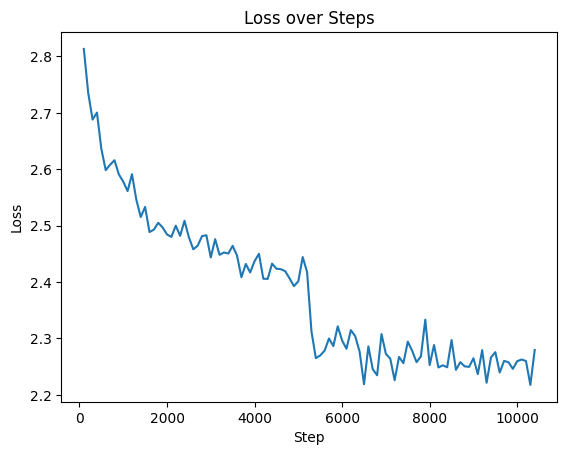

In [56]:

log_dir = "/Users/ashishsinha/Documents/workspace/alpaca-sft/runs/Feb01_09-05-34_c30dfc889927"
ea = event_accumulator.EventAccumulator(
    log_dir,
    size_guidance={
        event_accumulator.SCALARS: 0,   # load all
    }
)

ea.Reload()

pprint(f"Available tags: {ea.Tags()["scalars"]}")

tag = "train/loss"

events = ea.Scalars(tag)

df = pd.DataFrame(events)
df.rename(columns={
    "wall_time": "time",
    "step": "step",
    "value": "value"
}, inplace=True)

print(df.head())

plt.plot(df['step'], df['value'])
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss over Steps')
plt.show()

## Comparing the outputs from the trained model vs the base model

In [ ]:
def generate_answer(prompt, max_new_tokens=50):
    ids = tokenizer.encode(prompt, return_tensors="pt").to('cuda:0')
    out = model.generate(ids, max_new_tokens=max_new_tokens)
    return tokenizer.decode(out[0])

print(generate_answer("Explain machine learning in few words. "))
print(generate_answer("Explain supervised fine-tuning simply. "))

In [ ]:
# re-create the base model for comparison
vanila_model = AutoModelForCausalLM.from_pretrained(model_name).to('cuda:0')

def generate_answer(prompt, max_new_tokens=30):
    ids = tokenizer.encode(prompt, return_tensors="pt").to('cuda:0')
    out = vanila_model.generate(ids, max_new_tokens=max_new_tokens)
    return tokenizer.decode(out[0])

print(generate_answer("Explain machine learning in few words. "))
print(generate_answer("Explain supervised fine-tuning simply. "))

For the prompt - "Explain supervised fine-tuning simply. "

- **Base model output**:
Explain supervised fine-tuning simply.  
The first step is to use the following command to make sure that the code is executed correctly.
$ ./bin/sh -r

- **Fine-tuned model output**:
Explain supervised fine-tuning simply. 
The supervised fine-tuning is a technique used to fine-tune a certain object or process. It involves the use of a combination of the input and output of the input. The fine-tune process is used to fine-t

For the prompt : "Explain machine learning in few words. "

- **Base model output**:
Explain machine learning in few words.  
The first thing I noticed was that the first thing I noticed was that the first thing I noticed was that the first thing I noticed was
Explain supervised fine-tuning simply. 

- **Fine-tuned model output**:
Explain machine learning in few words. 
Machine learning is a branch of computer science that focuses on the development of algorithms that can learn from data and make predictions based on the data. It is used to develop algorithms that can learn from data and make predictions based on the data. It is


The fine-tuned model provides more relevant and coherent responses compared to the base model, demonstrating the effectiveness of supervised fine-tuning in aligning the model's outputs with desired behaviors.

## Conclusion

Supervised Fine-Tuning transforms general-purpose language models into instruction-following assistants.
By using the Alpaca dataset and our custom data formatting, we demonstrated:

- how to prepare prompt + response
- how to mask loss correctly
- how to train a model end-to-end
- how to inspect outputs

This foundational understanding is essential before moving to more advanced techniques like preference learning (DPO/RLHF) or parameter-efficient tuning (LoRA / QLoRA).

## References

- Alpcaca Dataset: https://huggingface.co/datasets/tatsu-lab/alpaca
- Hugging Face Transformers: https://huggingface.co/docs/transformers/index
- distilgpt2 model: https://huggingface.co/distilgpt2